In [1]:
import re, os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unicodecsv as csv
import seaborn as sns
from collections import Counter
from cycler import cycler
from textwrap import wrap
from IPython.display import display, HTML, Markdown

In [2]:
# Define an iterator for reading rows.
def rows_iter(index=True):
    if index:
        for index, (line, ticker) in enumerate(rows_iter(index=False)):
             yield index, line, ticker
    else:
        empl_path = [r"../banks_big/",r"../banks_small/",r"../tech/"]
        empl_file_lst = [(y+x,x[:-4].upper()) for y in empl_path for x in os.listdir(y)]
        for empl_file, ticker in empl_file_lst:
            with open(empl_file,"rb") as f:
                reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
                for line in reader:
                    del line[1]
                    yield line, {
                        "BAC":"BAC","CITI":"C","GS":"GS","JPM":"JPM","MS":"MS","WFC":"WFC",
                        "BOH":"BOH","FITB":"FITB","SNV":"SNV","SVB":"SIVB","UMP":"UMPQ",
                        "MSFT":"MSFT","AMZN":"AMZN","GOOG":"GOOG","IBM":"IBM"
                    }[ticker]

In [3]:
# Read data.
ticker_this = None
res_dict = {}
for idx, entry, ticker in rows_iter():
    if idx == None: # End point.
        break
    if ticker != ticker_this:
        ticker_this = ticker
        res_dict[ticker] = Counter([])
    if entry[21] == ticker_this and entry[26] == "False":
        if entry[11] != "None" and (entry[13] != "None" or entry[15] == "True"):
            res_dict[ticker].update(
                range(
                    pd.to_datetime(entry[11]).year,
                    pd.to_datetime(entry[13]).year if entry[13]!="None" else 2019
                )
            )

empl_by_years = pd.DataFrame(res_dict).fillna(0).unstack().reset_index()
empl_by_years.columns = ["ticker", "year", "employment"]
empl_by_years = empl_by_years.assign(employment=lambda df:df["employment"]/1000)


In [ ]:
# Read Compustat data.
empl_compustat_df = pd.read_csv("../employees.csv")
assert not empl_compustat_df.duplicated(["fyear","tic"]).any()
empl_compustat_df = empl_compustat_df[["fyear", "tic", "emp"]]
empl_compustat_df.columns = ["year","ticker","empl_compustat"]

In [4]:
# A iterator for plots.
number_of_uniques = len(empl_by_years["ticker"].unique())
def iterator_for_axis(col=1, one_size=(12,6), rep_time=1, number_once=number_of_uniques, fig_func=None):
    all_needs=number_once*rep_time
    row=-(-all_needs//col)
    fig, axs = plt.subplots(row,col,figsize=(one_size[0]*col, one_size[1]*row))
    if col>1 and row>1:
        axs=[x for y in axs for x in y]
    elif col==1 and row==1:
        axs=[axs]
    if fig_func is not None:
        fig_func(fig)
    for ax in axs[all_needs:]:
        ax.axis('off')
    return iter(axs)

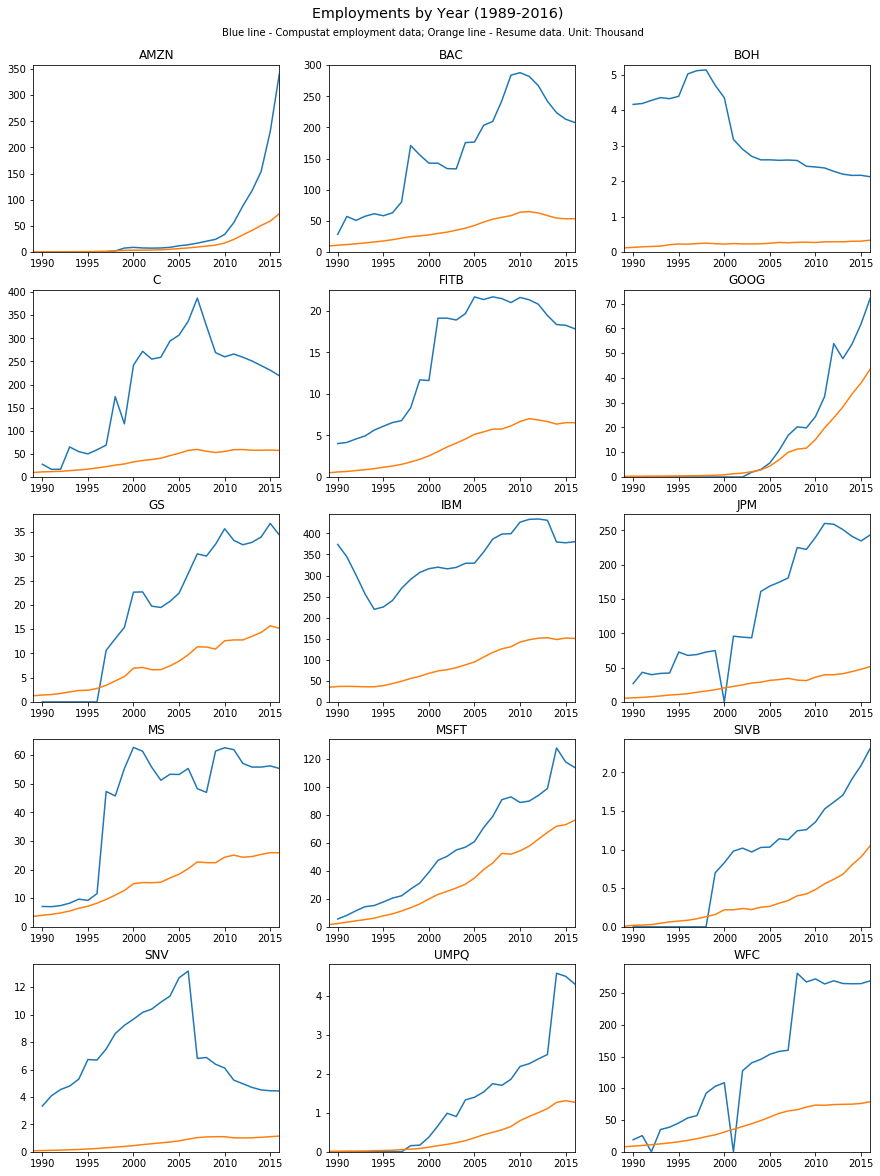

In [18]:
# Plot.
def fig_func(fig):
    fig.suptitle("Employments by Year (1989-2016)",fontsize="x-large",y=0.92)
    fig.text(0.3,0.9,"Blue line - Compustat employment data; Orange line - Resume data. Unit: Thousand")

for (ticker, col), (_, col_2), ax in zip(
    empl_by_years.pivot_table(
        index='year',columns='ticker',values='employment',fill_value=0
    ).loc[lambda df:(df.index>=1989)&(df.index<=2016)].iteritems(),
    empl_compustat_df.pivot_table(
        index='year',columns='ticker',values="empl_compustat",fill_value=0
    ).loc[lambda df:(df.index>=1989)&(df.index<=2016)].iteritems(),
    iterator_for_axis(col=3, one_size=(5,4), fig_func=fig_func)
):
    col_2.plot(ax=ax, title=ticker).set_ylim(bottom=0)
    col.plot(ax=ax, title=ticker).set_ylim(bottom=0)
    ax.set_xlabel("")
    
plt.show()

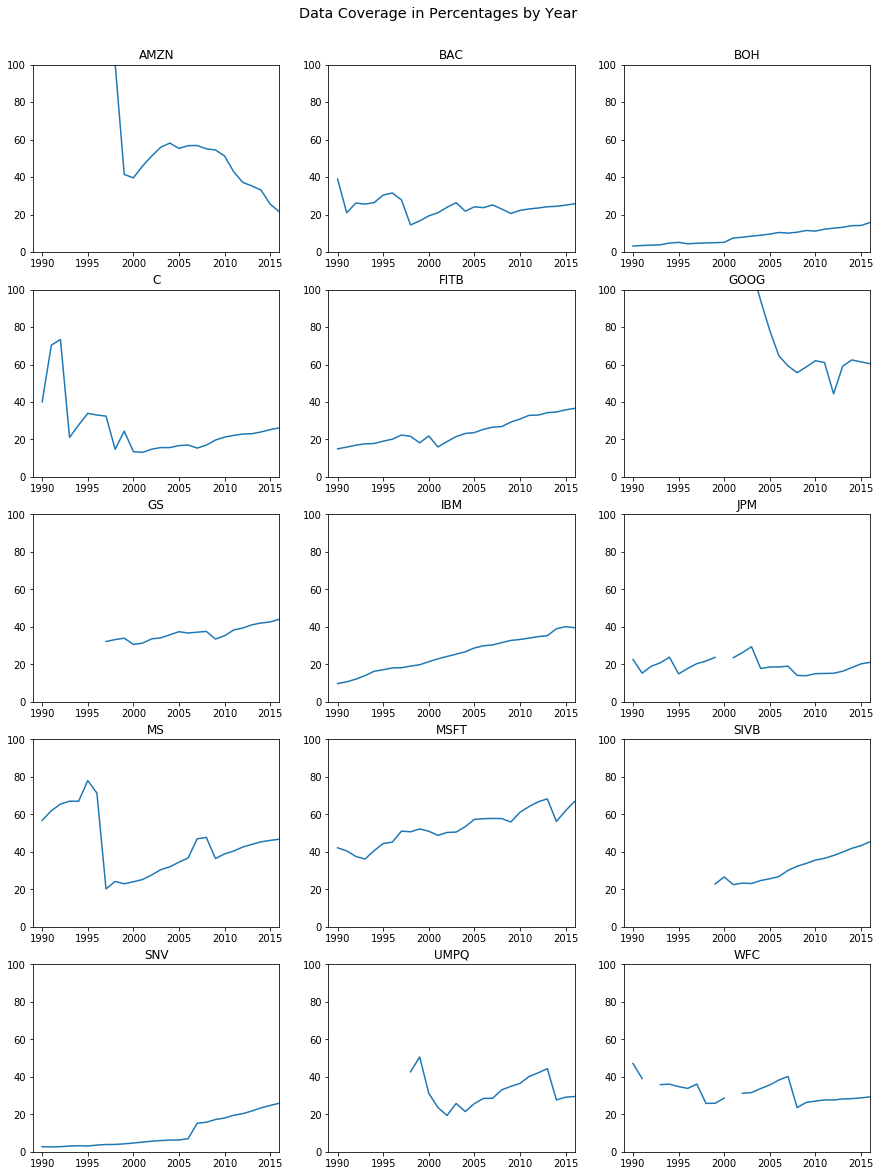

In [25]:
# Percentages.
percentage_df = (empl_by_years.pivot_table(
    index='year',columns='ticker',values='employment',fill_value=0
).loc[lambda df:(df.index>=1989)&(df.index<=2016)]/empl_compustat_df.pivot_table(
    index='year',columns='ticker',values="empl_compustat",fill_value=0
).loc[lambda df:(df.index>=1989)&(df.index<=2016)].rename(columns = {'GOOGL':'GOOG'})*100)
percentage_df

# Plot.
def fig_func(fig):
    fig.suptitle("Data Coverage in Percentages by Year",fontsize="x-large",y=0.92)

for (ticker, col), ax in zip(
    percentage_df.iteritems(),
    iterator_for_axis(col=3, one_size=(5,4), fig_func=fig_func)
):
    col.plot(ax=ax, title=ticker).set_ylim(bottom=0, top=100)
    ax.set_xlabel("")
    
plt.show()